**Part 1**

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

import requests
import json

import os
import pandas as pd
import numpy as np
import time
from bs4 import BeautifulSoup

from IPython.core.display import HTML, display

In [2]:
def get_soup(link):
    '''
    Function accepts a link and returns a BeautifulSoup object parsed from text of a succesful GET request on a link. If requests returns other status code than 200, returns None and prints a message

    Make sure that the request object is parsed as UTF-8 string.
    '''

   
    r = requests.get(link)
    if r.status_code ==200:
        pass
    else:
        print(f"wrong status code{r.status_code}")
    r.encoding = 'UTF-8'
    return BeautifulSoup(r.text)


In [3]:
soup=get_soup("https://en.wikipedia.org/wiki/FTSE_100_Index")

In [15]:
soup_table=soup.find('table',{'id':'constituents'}).find('tbody').findAll('tr')[1:]

In [24]:
#get a title from one row of a table
soup_table[0].find('a')['title']

'3i'

In [31]:
#get a ticker
soup_table[0].findAll('td')[1].text

'III'

In [43]:
#get industry
soup_table[0].findAll('td')[2].text.strip()

'Financial Services'

In [41]:
#create the required data frame
df=pd.DataFrame({})
for row in soup_table:
        Title=row.find('a')['title']
        Ticker=row.findAll('td')[1].text
        Industry=row.findAll('td')[2].text.strip()
        pd_ser=pd.Series({"Ticker":Ticker,"Industry":Industry},name=Title)
        df=pd.concat([df, pd_ser], axis='columns')

In [63]:
df_part1=df
df

,3i,Admiral Group,Anglo American plc,Antofagasta PLC,Ashtead Group,Associated British Foods,AstraZeneca,Auto Trader Group,Avast,Aveva,...,Standard Chartered,Standard Life Aberdeen,St. James's Place plc,Taylor Wimpey,Tesco,Unilever,United Utilities,Vodafone,Whitbread,WPP plc
Ticker,III,ADM,AAL,ANTO,AHT,ABF,AZN,AUTO,AVST,AVV,...,STAN,SLA,STJ,TW.,TSCO,ULVR,UU.,VOD,WTB,WPP
Industry,Financial Services,Nonlife Insurance,Mining,Mining,Support Services,Food Producers,Pharmaceuticals & Biotechnology,Media,Software and Computer Services,Software & Computer Services,...,Banks,Financial Services,Life Insurance,Household Goods & Home Construction,Food & Drug Retailers,Personal Goods,"Gas, Water & Multi-utilities",Mobile Telecommunications,Retail hospitality,Media


**Part 2**

In [46]:
#1. post request
API_ENDPOINT_1='https://ies-midterm.soulution.rocks/login'
r = requests.post(url = API_ENDPOINT_1, data = {"cuni":'32563404'})

In [53]:
r

<Response [200]>

In [49]:
r.text

'{"data": {}, "message": "Error [400] - invalid JSON payload. Submit a JSON string."}'

In [51]:
#try again
type(json.dumps({"cuni":'32563404'}))
r = requests.post(url = API_ENDPOINT_1, data = json.dumps({"cuni":'32563404'}) )

In [52]:
r

<Response [200]>

In [54]:
d=r.json()

print(type(d))

<class 'dict'>


In [55]:
d.keys()

dict_keys(['data', 'message'])

In [56]:
r.text

'{"data": {"personal_code": "d7c0fb21cb", "dataset_ids": [["7be200ce5b", "f45ec2e9fc", "f36bd332b4", "64a5d99db0", "95ff551368"]]}, "message": "Hello, Kol\\u00e1\\u0159 Daniel! Good luck with the midterm. GET your data set from /data/file_id endpoint; use the codes you received in the data response as the file_id parameter! Print the personal code in your notebook."}'

In [57]:
#printing personal ID
print(d['data']['personal_code'])

d7c0fb21cb


In [61]:
#dataset_IDs
d_id=d['data']['dataset_ids'][0]
print(d_id[0])

7be200ce5b


In [88]:
#2. get request
l=[]
for id in d_id:
    r=requests.get(url=f'https://ies-midterm.soulution.rocks/data/{id}')
    time.sleep(.3)
    while r.status_code != 200:   #try again
        r=requests.get(url=f'https://ies-midterm.soulution.rocks/data/{id}')
        time.sleep(.3)
    d=r.json()
    l.append(d)
        
#now we have a list of jsons with some stock market data


**Part 3**

Analyze scraping output

In [112]:
#Scraping output: how many industries?
industry_count=df_part1.T.groupby("Industry").count()
industry_count.head(5)

,Ticker
Industry,
Aerospace & Defence,2
Asset Managers,1
Automobiles & Parts,1
Banks,5
Beverages,2


In [115]:
industry_count.max()

Ticker    8
dtype: int64

In [116]:
#here is the maximum
industry_count[industry_count["Ticker"]==8]

,Ticker
Industry,
Support Services,8


In [117]:
industry_count.min()

Ticker    1
dtype: int64

In [118]:
#here is the minimum
industry_count[industry_count["Ticker"]==1]

,Ticker
Industry,
Asset Managers,1
Automobiles & Parts,1
Construction & Materials,1
Consumer services,1
Electricity,1
Electronic & Electrical Equipment,1
Equity Investment Instruments,1
Fixed Line Telecommunications,1
Food Producers,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022633BF6550>]],
      dtype=object)

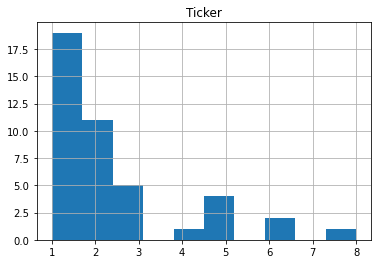

In [132]:
#histogram
industry_count.hist()


Analysis of dataset

In [164]:
#first create a pd Data Frame from json for each stock
def json_to_df(list):
    df_1=pd.DataFrame(list['data']['data']).set_index("Date")
    df_1["Ticker"]=list['data']['company']
    return df_1

In [165]:
data=pd.concat([json_to_df(list) for list in l],axis="rows")

In [166]:
data.index=pd.to_datetime(data.index)

In [170]:
data=data.dropna()

In [192]:
data.loc[:,["Ticker","Adj.Close"]].groupby(["Ticker"]).max()
#I should have changed the data type of Adj.Close to a float

DataError: No numeric types to aggregate